### Import

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report


In [12]:
data = pd.read_csv(r'C:\repositorio\Student-Depression-Prediction-RandomForest\data\processed\cleaned_student_depression_dataset.csv')
data.head()

,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,1,33.0,5.0,0.0,8.97,2.0,0.0,2,3,1,3.0,1.0,0,1
1,0,24.0,2.0,0.0,5.90,5.0,0.0,2,2,0,3.0,2.0,1,0
2,1,31.0,3.0,0.0,7.03,5.0,0.0,1,3,0,9.0,1.0,1,0
3,0,28.0,3.0,0.0,5.59,2.0,0.0,3,2,1,4.0,5.0,1,1
4,0,25.0,4.0,0.0,8.13,3.0,0.0,2,2,1,1.0,1.0,0,0


### Separando variáveis de treino e de teste

In [ ]:
X = data.drop(columns=['Depression'])  
y = data['Depression'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

Tamanho do conjunto de treino: (22305, 13)
Tamanho do conjunto de teste: (5577, 13)


In [41]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)      

### Selecionando os melhores hiperparâmetros

In [30]:
from sklearn.model_selection import GridSearchCV

# Definir os hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar o Grid Search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # Validação cruzada com 5 folds
                           scoring='accuracy',
                           n_jobs=-1)  # Usar todos os núcleos do processador

# Executar o Grid Search
grid_search.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid_search.best_params_)

# Treinar o modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_

Melhores hiperparâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


### Treinando o modelo com os Hiperparâmentros encontrados

In [42]:
model = RandomForestClassifier(max_depth=10,min_samples_leaf=2,min_samples_split=10,n_estimators=300, random_state=42)

# Treinar o modelo
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=300, random_state=42)

In [43]:
y_pred = model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.2f}")

Acurácia do modelo: 0.84


### Vizualizando a matriz de confusão 
#### Modelo previu: 
- 1810 Verdadeiros positivos 
- 2892 Verdadeiros negativos

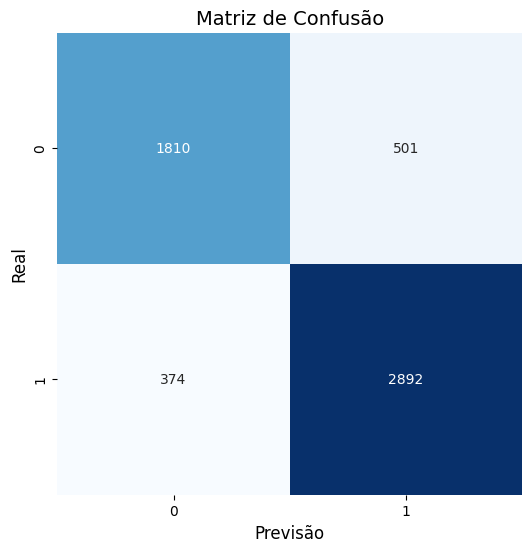

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão', fontsize=14)
plt.xlabel('Previsão', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

### Vizualizando a curva ROC
- Quanto mais próximo de 1.0 mais preciso.

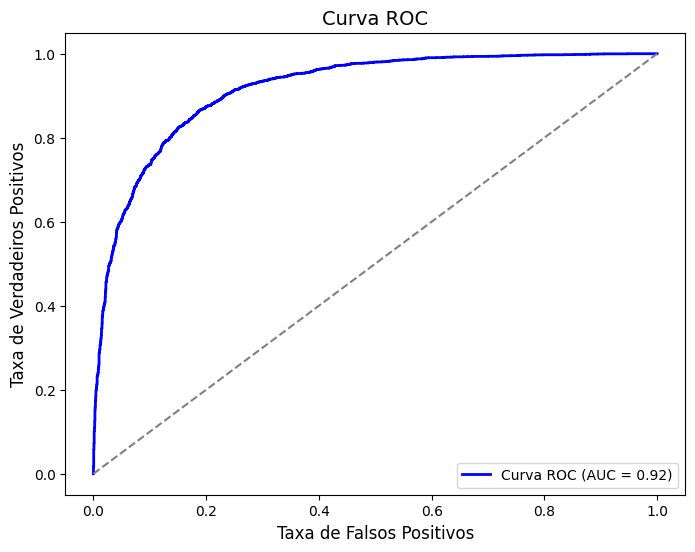

In [34]:

y_prob = model.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curva ROC', fontsize=14)
plt.legend(loc='lower right')
plt.show()

In [44]:
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      2311
           1       0.85      0.89      0.87      3266

    accuracy                           0.84      5577
   macro avg       0.84      0.83      0.84      5577
weighted avg       0.84      0.84      0.84      5577



### Vizualizando a importância das Features no modelo

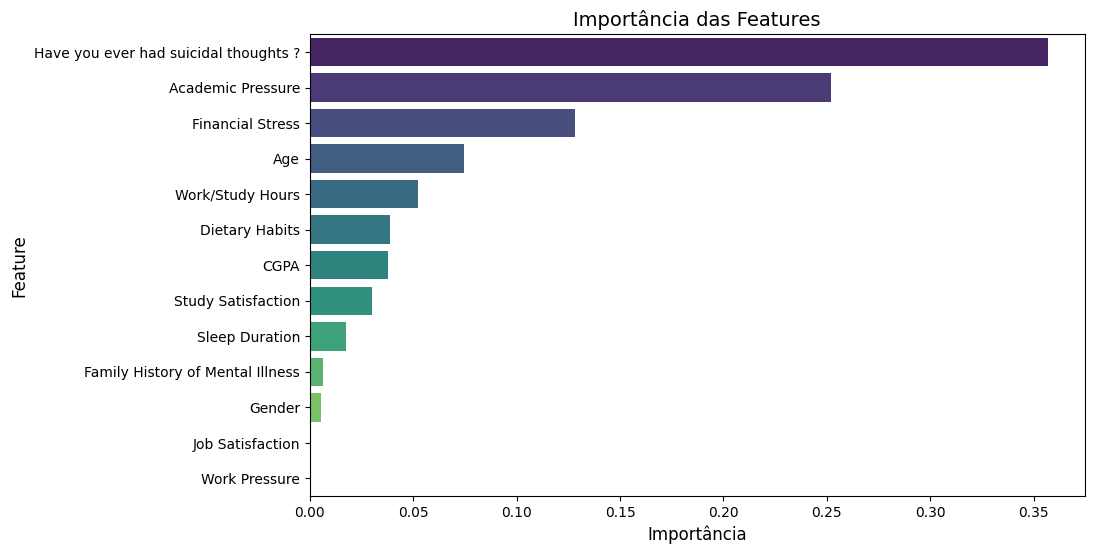

In [52]:
# Obter a importância das features
feature_importance = model.feature_importances_

# Criar um DataFrame para visualização
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plotar a importância das features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis',hue='Feature')
plt.title('Importância das Features', fontsize=14)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

### Salvando o Modelo

In [37]:
import pickle

# Salvar o modelo em um arquivo .pkl
with open(r'C:\repositorio\Student-Depression-Prediction-RandomForest\models\random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)
